In [ ]:
import csv
import dateutil
import gzip
import math
import numpy
import random
import sklearn
import string
import datetime
from sklearn import tree
from sklearn.model_selection import train_test_split

from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn.manifold import TSNE
from sklearn import linear_model
import dateutil
def load_data():
    data = []

    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                d[label[i]] = elem
            data.append(d)
    print(len(data))
    return data


In [ ]:
#image.py
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import os
IMAGE_DIR = 'image_feature'
PIC_DIR = 'pic'

def load_overall_stat():
    with open(os.path.join(IMAGE_DIR,'/content/overall_stat.json'),'r') as fp:
        overall_stat = json.load(fp)
    return overall_stat

def load_each_image_stat():
    with open(os.path.join(IMAGE_DIR,'/content/each_image_stat.json'),'r') as fp:
        each_image_stat = json.load(fp)
    return each_image_stat

def feature_extraction():
  for attribute in ["number_of_comments","total_votes"]:
    image_vec = {}
    each_image_stat = load_each_image_stat()
    overall_stat = load_overall_stat()

    avg_number_of_upvotes = overall_stat.get('avg_number_of_upvotes')
    std_number_of_upvotes = overall_stat.get('std_number_of_upvotes')
    avg_number_of_comments = overall_stat.get('avg_number_of_comments')
    std_number_of_comments = overall_stat.get('std_number_of_comments')

    for image_id,value in each_image_stat.items():
        if attribute == 'number_of_comments':
            image_vec[image_id] = [1, float(value.get('avg_number_of_upvotes')-avg_number_of_upvotes)/std_number_of_upvotes] # normalize
        elif attribute == 'total_votes':
            image_vec[image_id] = [1, float(value.get('avg_number_of_comments')-avg_number_of_comments)/std_number_of_comments]
        else:
            print ('{0} is undefined.'.format(attribute))
            break

    with open(os.path.join(IMAGE_DIR,'/content/image_vec_number_of_comments.json'),'w') as f:
        json.dump(image_vec,f)
def _image():
    data = load_data()
    data = data[:int(len(data)/3)]
    each_image_stat = {}

    features = ['number_of_upvotes','number_of_downvotes','number_of_comments']
    for record in data:
        image_id = record.get('image_id')
        if image_id not in each_image_stat:
            each_image_stat[image_id] = defaultdict(float)
        for feature in features:
            each_image_stat[image_id]['avg_'+feature] += float(record.get(feature))
        each_image_stat[image_id]['num_of_posts'] += 1
    
    for image_id,stat in each_image_stat.items():
        for feature in features:
            each_image_stat[image_id]['avg_'+feature] /= each_image_stat[image_id]['num_of_posts']
        each_image_stat[image_id] = dict(each_image_stat[image_id])
    
    number_of_upvotes = []
    for record in data:
     number_of_upvotes.append(int(record.get('number_of_upvotes')))
    number_of_downvotes = []
    for record in data:
     number_of_downvotes.append(int(record.get('number_of_downvotes')))
    number_of_comments = []
    for record in data:
     number_of_comments.append(int(record.get('number_of_comments')))


    overall_stat = {
        'avg_number_of_upvotes': np.mean(number_of_upvotes),
        'avg_number_of_downvotes': np.mean(number_of_downvotes),
        'avg_number_of_comments': np.mean(number_of_comments),
        'std_number_of_upvotes': np.std(number_of_upvotes),
        'std_number_of_downvotes': np.std(number_of_downvotes),
        'std_number_of_comments': np.std(number_of_comments)
    }

    with open(os.path.join(IMAGE_DIR,'/content/each_image_stat.json'),'w') as fp:
        json.dump(dict(each_image_stat),fp)
    with open(os.path.join(IMAGE_DIR,'/content/overall_stat.json'),'w') as fp:
        json.dump(overall_stat,fp)

 

if __name__ == '__main__':
    _image()
    feature_extraction()



32268


In [ ]:
#user_name
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import os
USER_DIR = 'user_feature'
PIC_DIR = 'pics'
def all_users_data():
    with open(os.path.join(USER_DIR,'/content/all_users_data.json'),'r') as f:
        all_users_data = json.load(f)
    return all_users_data

def _load_user_stat():
    with open(os.path.join(USER_DIR,'user_stat.json'),'r') as f:
        user_stat = json.load(f)
    return user_stat


def _username():
    data = load_data()
    data = data[:len(data)/3]
    user_post_num = defaultdict(int)
    user_down_vote = defaultdict(int)
    user_up_vote = defaultdict(int)
    user_vote = defaultdict(int)
    user_comment_num = defaultdict(int)

    for record in data:
        user_name = record.get('username')
        user_post_num[user_name] += 1
        user_comment_num[user_name] += int(record.get('number_of_comments'))
        user_down_vote[user_name] += int(record.get('number_of_downvotes'))
        user_up_vote[user_name] += int(record.get('number_of_upvotes'))
        user_vote[user_name] += int(record.get('total_votes'))

    post_num_list = sorted(user_post_num.items(),key=lambda item:item[1], reverse=True)
    avg_post_num = np.mean(user_post_num.values())
    median_post_num = np.median(user_post_num.values())
    std_post_num = np.std(user_post_num.values())

    avg_votes = np.mean(user_vote.values())
    std_votes = np.std(user_vote.values())

    avg_comments = np.mean(user_comment_num.values())
    std_comments = np.std(user_comment_num.values())

    def user_profile(user_name):
        profile = {
            'username':user_name,
            'num_of_post':user_post_num[user_name],
            'avg_comments':float(user_comment_num[user_name])/user_post_num[user_name],
            'avg_downvotes':float(user_down_vote[user_name])/user_post_num[user_name],
            'avg_upvotes':float(user_up_vote[user_name])/user_post_num[user_name],
            'avg_votes':float(user_vote[user_name])/user_post_num[user_name],
        }
        return profile

    each_user_profile = [user_profile(user) for user in user_post_num.keys()]

    result = {
        'top_10':[user_profile(ele[0]) for ele in post_num_list[:10]],
        'bottom_10':[user_profile(ele[0]) for ele in post_num_list[-10:]],
        'avg_post_num':avg_post_num,
        'median_post_num':median_post_num,
        'avg_votes':avg_votes,
        'std_votes':std_votes,
        'avg_comments':avg_comments,
        'std_comments':std_comments
    }

    with open(os.path.join(USER_DIR,'each_user_profile.json'),'w') as f:
        json.dump(each_user_profile,f)

    with open(os.path.join(USER_DIR,'user_stat.json'),'w') as f:
        json.dump(result,f)

    with open(os.path.join(USER_DIR,'all_user_post_num.json'),'w') as f:
        json.dump(dict(user_post_num),f)

def gen_feature(target):
    user_vec = {}
    user_stat = _load_user_stat()
    user_profile = all_users_data()
    total_avg_comments = user_stat['avg_comments']
    total_std_comments = user_stat['std_comments']
    total_avg_votes = user_stat['avg_votes']
    total_std_votes = user_stat['std_votes']
    
    for user in user_profile:
        user_name = user.get('username')
        avg_comments = user.get('avg_comments')
        avg_votes = user.get('avg_votes')
        if target == "number_of_comments":        
            user_vec[user_name] = [1,float(avg_votes-total_avg_votes)/total_std_votes]
        elif target == 'total_votes':
            user_vec[user_name] = [1,float(avg_comments-total_avg_comments)/total_std_comments]
        else:
            print('{0} is undefined.'.format(target))
            break

    with open(os.path.join(USER_DIR,'user_vec_'+target+'.json'),'w') as f:
        json.dump(user_vec,f)
def _evaluate():
    each_user_profile = all_users_data()
    post_list = []
    comment_list = []
    votes_list = []
    for user in each_user_profile:
        post_list.append(user.get('num_of_post'))
        comment_list.append(user.get('avg_comments'))
        votes_list.append(user.get('avg_votes')+ user.get('avg_comments'))
    
    result = {"post_num_vs_votes":np.corrcoef(post_list,votes_list).tolist(),
    "post_num_vs_comments": np.corrcoef(post_list,comment_list).tolist(),
    "votes_vs_comments":np.corrcoef(votes_list,comment_list).tolist()
    }
    with open(os.path.join(USER_DIR,'/content/correlation_matrix.json'),'w') as fp:
        json.dump(result,fp)

    plt.bar(comment_list,votes_list, color ='maroon',width = 0.4)

    plt.ylabel("average comments and votes (attention) of user")
    plt.xlabel("average number of the comments the user obtained")
    plt.title("votes VS comments")
    plt.xlim([0, 1500])     

if __name__ == '__main__':
    _evaluate()



    

In [ ]:
# linear model.py
import csv
import nltk
nltk.download('stopwords')
data = []

label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
'undefined1','undefined2', 'undefined3']

with open('submissions.csv', newline='', encoding='utf-8') as csvfile:
    csvReader = csv.reader(csvfile)
    for row in csvReader:
        if row[0] == '#image_id':
            continue
        d = {}
        for i,elem in enumerate(row):
            d[label[i]] = elem
        data.append(d)

# word count (title)
from collections import defaultdict
import string
wordCount = defaultdict(int)
punctuation = set(string.punctuation)

for d in data:
    r = ''.join([c for c in d['title'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

print(len(wordCount))

from nltk.corpus import stopwords
for w in stopwords.words("english"):
    if w in wordCount:
        wordCount.pop(w)

print(len(wordCount))
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

# output top 50 frequent words in title
f = open('/content/top50_words_in_title.txt','w')

for x in range(50):
    f.write(counts[x][1] + ': ' + str(counts[x][0]) + '\n')

f.close()

# take top 1000 words to be our targets
words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['title'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


38064
37926


In [ ]:
####unigrams
y_user_interaction = []
X=[]
for d in data:
#  if ((int(d['total_votes'])+int(d['number_of_comments'])) <=10000):
      X.append(feature(d))
      y_user_interaction.append(int(d['total_votes'])+int(d['number_of_comments']))
y_upvotes = [int(d['number_of_upvotes']) for d in data]
y_downvotes = [int(d['number_of_downvotes']) for d in data]
y_score = [int(d['score']) for d in data]
y_user_interaction = [int(d['total_votes'])+int(d['number_of_comments']) for d in data]
mean = sum(y_user_interaction)/len(y_user_interaction)
y_user_interaction = [(x/10000) for x in y_user_interaction] 
#normalization

Ntrain,Ntest = 100000,20000
Xtrain,Xtest = X[:Ntrain],X[Ntrain: Ntrain+Ntest]
ytrain,ytest = y_user_interaction[:Ntrain],y_user_interaction[Ntrain: Ntrain+Ntest]


from sklearn import linear_model
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain,ytrain)
theta = clf.coef_

#store word-theta pairs
f = open('model_coeeficients.txt','w')

for x in range(len(theta)):
    try:
        f.write(words[x] + ': ' + str(theta[x]) + '\n')
    except Exception as e:
        pass

f.close()
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)
predictions = clf.predict(Xtest)
print(predictions)
print(y_user_interaction)
y = ytest
mse1 = MSE(y,predictions)
print(mse1)

[0.10725551 0.3323232  0.25645304 ... 0.20272986 0.20272986 0.13704597]
[6.4092, 0.0038, 0.0041, 0.001, 0.0065, 0.0043, 0.0116, 0.0013, 0.0014, 0.002, 0.0021, 0.0276, 0.8558, 0.0027, 0.0024, 0.0024, 0.0025, 0.0014, 0.0014, 0.0001, 0.0173, 0.001, 0.0056, 0.0014, 0.0003, 0.0271, 0.0025, 0.009, 0.0004, 0.0145, 1.3415, 0.0017, 0.0008, 0.0013, 0.0005, 1.5456, 0.0013, 0.0021, 0.0013, 0.0008, 0.0012, 0.0009, 0.0015, 0.001, 0.002, 0.0071, 1.5791, 0.0006, 0.001, 0.0021, 0.0045, 0.0066, 0.0111, 0.0163, 0.0023, 0.0012, 0.189, 0.0171, 0.005, 0.4571, 0.0011, 0.0138, 1.6248, 0.5124, 0.0026, 0.0015, 0.0261, 0.0021, 2.626, 0.0038, 0.4762, 0.0018, 2.2222, 0.0075, 0.0066, 0.0057, 0.0181, 0.0341, 0.0532, 0.0052, 0.0087, 0.0046, 0.1975, 0.0278, 0.0594, 0.0112, 0.421, 0.0108, 0.0446, 0.0044, 0.0259, 0.4278, 0.0025, 0.0212, 0.0007, 0.0036, 0.0031, 0.0073, 0.1116, 0.0013, 0.0098, 0.0017, 0.0007, 0.0035, 0.0037, 0.0003, 0.0002, 5.7468, 0.0888, 0.002, 0.013, 0.0057, 0.0027, 0.0005, 3.8041, 0.003, 0.0024, 0.015

In [ ]:
#Text classification using transformers

!pip install -U sentence-transformers -q





     |████████████████████████████████| 85 kB 1.8 MB/s 
     |████████████████████████████████| 5.5 MB 25.8 MB/s 
     |████████████████████████████████| 1.3 MB 50.1 MB/s 
     |████████████████████████████████| 182 kB 73.3 MB/s 
     |████████████████████████████████| 7.6 MB 61.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
np.random.seed(2022)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

import spacy
import string
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)


punctuations = string.punctuation
print(punctuations)


# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(sentence)



    # print(doc)
    # print(type(doc))

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # print(mytokens)

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    sentence = " ".join(mytokens)
    # return preprocessed list of tokens
    return sentence
spacy_tokenizer("I am Eating")
final_dataset = load_data()
final_dataset = pd.DataFrame(final_dataset)
final_dataset = final_dataset[1:5000]

y = final_dataset['subreddit'].to_list()
m=[]
len(set(y))
for k in set(y):
  if(y.count(k) ==1):
    m.append(k)

final_dataset = final_dataset[['subreddit','title']]
for k in m:
 final_dataset.drop(final_dataset[(final_dataset['subreddit'] == k)].index, inplace=True)

final_dataset['tokenize'] = final_dataset['title'].apply(spacy_tokenizer)

final_dataset['embeddings'] = final_dataset['tokenize'].apply(model.encode)
X = final_dataset['embeddings'].to_list()
y = final_dataset['subreddit'].to_list()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train)
from sklearn import metrics
predicted = LR.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted,pos_label='positive',average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted,pos_label='positive',average='micro'))

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

{'others', 'same', 'thus', 'various', 'your', 'else', 'doing', 'myself', 'nine', 'together', 'nor', 'such', 'nowhere', 'could', 'among', 'there', 'through', 'make', 'very', '’ve', 'meanwhile', 'almost', 'than', 'why', 'each', 'moreover', 'us', 'for', 'also', 'about', 'take', 'whenever', 'another', 'whither', 'own', 'seems', 'although', 'over', 'side', 'yet', 'between', 'elsewhere', 'might', 'our', 'per', 'any', 'due', 'eleven', 'my', 'anyhow', 'nothing', 'none', 'every', 'say', 'hence', 'with', 'would', 'should', 'throughout', 'much', 'herein', 'may', 'whereby', 'somewhere', 'those', 'became', 'whom', 'made', 'whoever', 'down', 'mine', 'becomes', 'done', 'during', 'still', 'become', 'ten', 'are', 'never', 'these', 'be', 'call', 'really', 'forty', 'hereafter', 'were', 'latterly', 'not', '’s', 'his', 'you', 'thereafter', 'thru', 'whose', 'ours', 'beside', 'which', 'thence', 'its', 'into', 'an', 'being', 'already', 'was', 'besides', 'ca', 'he', "'m", 'empty', 'just', '‘ll', 'someone', 'wh

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Logistic Regression Accuracy: 0.47914547304170907
Logistic Regression Precision: 0.47914547304170907
Logistic Regression Recall: 0.47914547304170907


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to spec

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

import spacy
import string
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)


punctuations = string.punctuation
print(punctuations)


# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(sentence)



    # print(doc)
    # print(type(doc))

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # print(mytokens)

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    sentence = " ".join(mytokens)
    # return preprocessed list of tokens
    return sentence
spacy_tokenizer("I am Eating")
final_dataset = load_data()
final_dataset = pd.DataFrame(final_dataset)
final_dataset = final_dataset[1:5000]

y = final_dataset['subreddit'].to_list()
m=[]
len(set(y))
for k in set(y):
  if(y.count(k) ==1):
    m.append(k)

final_dataset = final_dataset[['subreddit','title']]
for k in m:
 final_dataset.drop(final_dataset[(final_dataset['subreddit'] == k)].index, inplace=True)

final_dataset['tokenize'] = final_dataset['title'].apply(spacy_tokenizer)

final_dataset['embeddings'] = final_dataset['tokenize'].apply(model.encode)
X = final_dataset['embeddings'].to_list()
y = final_dataset['subreddit'].to_list()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train)
from sklearn import metrics
predicted = LR.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted,pos_label='positive',average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted,pos_label='positive',average='micro'))

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

{'others', 'same', 'thus', 'various', 'your', 'else', 'doing', 'myself', 'nine', 'together', 'nor', 'such', 'nowhere', 'could', 'among', 'there', 'through', 'make', 'very', '’ve', 'meanwhile', 'almost', 'than', 'why', 'each', 'moreover', 'us', 'for', 'also', 'about', 'take', 'whenever', 'another', 'whither', 'own', 'seems', 'although', 'over', 'side', 'yet', 'between', 'elsewhere', 'might', 'our', 'per', 'any', 'due', 'eleven', 'my', 'anyhow', 'nothing', 'none', 'every', 'say', 'hence', 'with', 'would', 'should', 'throughout', 'much', 'herein', 'may', 'whereby', 'somewhere', 'those', 'became', 'whom', 'made', 'whoever', 'down', 'mine', 'becomes', 'done', 'during', 'still', 'become', 'ten', 'are', 'never', 'these', 'be', 'call', 'really', 'forty', 'hereafter', 'were', 'latterly', 'not', '’s', 'his', 'you', 'thereafter', 'thru', 'whose', 'ours', 'beside', 'which', 'thence', 'its', 'into', 'an', 'being', 'already', 'was', 'besides', 'ca', 'he', "'m", 'empty', 'just', '‘ll', 'someone', 'wh

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to spec

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

import spacy
import string
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)


punctuations = string.punctuation

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # print(mytokens)

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    sentence = " ".join(mytokens)
    # return preprocessed list of tokens
    return sentence
spacy_tokenizer("I am Eating")
final_dataset = load_data()
final_dataset = pd.DataFrame(final_dataset)

y = final_dataset['subreddit'].to_list()
m=[]
len(set(y))
for k in set(y):
  if(y.count(k) ==1):
    m.append(k)

final_dataset = final_dataset[['subreddit','title']]
for k in m:
 final_dataset.drop(final_dataset[(final_dataset['subreddit'] == k)].index, inplace=True)

final_dataset['tokenize'] = final_dataset['title'].apply(spacy_tokenizer)

final_dataset['embeddings'] = final_dataset['tokenize'].apply(model.encode)
X = final_dataset['embeddings'].to_list()
y = final_dataset['subreddit'].to_list()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train)
from sklearn import metrics
predicted = LR.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted,pos_label='positive',average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted,pos_label='positive',average='micro'))

{'others', 'same', 'thus', 'various', 'your', 'else', 'doing', 'myself', 'nine', 'together', 'nor', 'such', 'nowhere', 'could', 'among', 'there', 'through', 'make', 'very', '’ve', 'meanwhile', 'almost', 'than', 'why', 'each', 'moreover', 'us', 'for', 'also', 'about', 'take', 'whenever', 'another', 'whither', 'own', 'seems', 'although', 'over', 'side', 'yet', 'between', 'elsewhere', 'might', 'our', 'per', 'any', 'due', 'eleven', 'my', 'anyhow', 'nothing', 'none', 'every', 'say', 'hence', 'with', 'would', 'should', 'throughout', 'much', 'herein', 'may', 'whereby', 'somewhere', 'those', 'became', 'whom', 'made', 'whoever', 'down', 'mine', 'becomes', 'done', 'during', 'still', 'become', 'ten', 'are', 'never', 'these', 'be', 'call', 'really', 'forty', 'hereafter', 'were', 'latterly', 'not', '’s', 'his', 'you', 'thereafter', 'thru', 'whose', 'ours', 'beside', 'which', 'thence', 'its', 'into', 'an', 'being', 'already', 'was', 'besides', 'ca', 'he', "'m", 'empty', 'just', '‘ll', 'someone', 'wh

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.47667058333017476
Logistic Regression Precision: 0.47667058333017476


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Logistic Regression Recall: 0.47667058333017476


In [ ]:
#the 1,000 most common unigrams;
# (b) the 1,000 most common bigrams;
# (c) a model which uses a combination of unigrams and bigrams (i.e., some bigrams will be included if
# they are more popular than some unigrams, but the model dimensionality will still be 1,000).

bigramCount = defaultdict(int)
for d in data:
  r = ''.join([c for c in d['title'].lower() if not c in punctuation])
  words = r.split()
  for i in range(0,len(words)-1):
    bigram = words[i] + " " + words[i+1]
    bigramCount[bigram] += 1

In [ ]:
countsBigram = [(bigramCount[d], d) for d in bigramCount.keys()]
countsBigram.sort()
countsBigram.reverse()
bigrams = [c[1] for c in countsBigram[:1000]]
bigramId = dict(zip(bigrams, range(len(bigrams))))
bigramSet = set(bigrams)
def feature_bigrams(text): #feature function for bigrams model

  feat = [0]*len(bigrams)
  words = text.split()
  for i in range(len(words)-1):
    bigram = words[i] + " " + words[i+1]
    try:
      feat[bigramId[bigram]] += 1
    except KeyError:
      continue
  feat.append(1) #offset
  return feat
''' 
a model which uses a combination of unigrams and bigrams (i.e., some bigrams will be included if
they are more popular than some unigrams, but the model dimensionality will still be 1,000).
'''
unigramCount = defaultdict(int)
for d in data:
  r = ''.join([c for c in d['title'].lower() if not c in punctuation])
  for w in r.split():
    #w = stemmer.stem(w) # with stemming
    unigramCount[w] += 1
countsUnigram = [(unigramCount[w], w) for w in unigramCount]
countsUnigram.sort()
countsUnigram.reverse()
unigrams = [x[1] for x in countsUnigram[:1000]]
unigramId = dict(zip(unigrams, range(len(unigrams))))
unigramSet = set(unigrams)
countsCombined = countsUnigram+ countsBigram
e=0
if(e<1):
 e=e+1
countsCombined.sort()
countsCombined.reverse()
combineds = [x[1] for x in countsCombined[:1000]]
combinedId = dict(zip(combineds, range(len(combineds))))


def feature_uni_bigrams(text):
  feat = [0]*len(combineds)
  words = text.split()
  for i in range(len(words)-1):
    bigram = words[i] + " " + words[i+1]
    try:
      feat[combinedId[bigram]] += 1
    except KeyError:
      continue
  for w in words:
    try:
      feat[combinedId[w]] += 1
    except KeyError:
      continue
  feat.append(1) #offset
  return feat


In [ ]:

y_user_interaction = []
X=[]
reviewText = [''.join([c for c in datum['title'].lower() if not c in punctuation]) for datum in data]
for i in range(len(data)):
      X.append(feature_bigrams(reviewText[i]))
      y_user_interaction.append(int(d['total_votes'])+int(d['number_of_comments']))
# print(X[:5000])
y_upvotes = [int(d['number_of_upvotes']) for d in data]
y_downvotes = [int(d['number_of_downvotes']) for d in data]
y_score = [int(d['score']) for d in data]
y_user_interaction = [int(d['total_votes'])+int(d['number_of_comments']) for d in data]
mean = sum(y_user_interaction)/len(y_user_interaction)
y_user_interaction = [(x/10000) for x in y_user_interaction]

Ntrain,Ntest = 100000,20000
Xtrain,Xtest = X[:Ntrain],X[Ntrain: Ntrain+Ntest]
ytrain,ytest = y_user_interaction[:Ntrain],y_user_interaction[Ntrain: Ntrain+Ntest]


from sklearn import linear_model
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain,ytrain) # when using all set of data, MEMORY ERROR!!!
theta = clf.coef_

#store word-theta pairs
f = open('model_coeeficients.txt','w')

for x in range(len(theta)):
    try:
        f.write(words[x] + ': ' + str(theta[x]) + '\n')
    except Exception as e:
        pass

f.close()
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)
predictions = clf.predict(Xtest)
print(predictions)
print(y_user_interaction)
y = ytest
mse1 = MSE(y,predictions)
print(mse1)

[0.19839998 0.19839998 0.19839998 ... 0.19839998 0.19839998 0.17284612]
[6.4092, 0.0038, 0.0041, 0.001, 0.0065, 0.0043, 0.0116, 0.0013, 0.0014, 0.002, 0.0021, 0.0276, 0.8558, 0.0027, 0.0024, 0.0024, 0.0025, 0.0014, 0.0014, 0.0001, 0.0173, 0.001, 0.0056, 0.0014, 0.0003, 0.0271, 0.0025, 0.009, 0.0004, 0.0145, 1.3415, 0.0017, 0.0008, 0.0013, 0.0005, 1.5456, 0.0013, 0.0021, 0.0013, 0.0008, 0.0012, 0.0009, 0.0015, 0.001, 0.002, 0.0071, 1.5791, 0.0006, 0.001, 0.0021, 0.0045, 0.0066, 0.0111, 0.0163, 0.0023, 0.0012, 0.189, 0.0171, 0.005, 0.4571, 0.0011, 0.0138, 1.6248, 0.5124, 0.0026, 0.0015, 0.0261, 0.0021, 2.626, 0.0038, 0.4762, 0.0018, 2.2222, 0.0075, 0.0066, 0.0057, 0.0181, 0.0341, 0.0532, 0.0052, 0.0087, 0.0046, 0.1975, 0.0278, 0.0594, 0.0112, 0.421, 0.0108, 0.0446, 0.0044, 0.0259, 0.4278, 0.0025, 0.0212, 0.0007, 0.0036, 0.0031, 0.0073, 0.1116, 0.0013, 0.0098, 0.0017, 0.0007, 0.0035, 0.0037, 0.0003, 0.0002, 5.7468, 0.0888, 0.002, 0.013, 0.0057, 0.0027, 0.0005, 3.8041, 0.003, 0.0024, 0.015

In [ ]:
#model for combined unigrams and bigrams
y_user_interaction = []
X=[]
reviewText = [''.join([c for c in datum['title'].lower() if not c in punctuation]) for datum in data]
for i in range(len(data)):
      X.append(feature_uni_bigrams(reviewText[i]))
      y_user_interaction.append(int(d['total_votes'])+int(d['number_of_comments']))

y_upvotes = [int(d['number_of_upvotes']) for d in data]
y_downvotes = [int(d['number_of_downvotes']) for d in data]
y_score = [int(d['score']) for d in data]
y_user_interaction = [int(d['total_votes'])+int(d['number_of_comments']) for d in data]
mean = sum(y_user_interaction)/len(y_user_interaction)
y_user_interaction = [(x/10000) for x in y_user_interaction]

Ntrain,Ntest = 100000,20000
Xtrain,Xtest = X[:Ntrain],X[Ntrain: Ntrain+Ntest]
ytrain,ytest = y_user_interaction[:Ntrain],y_user_interaction[Ntrain: Ntrain+Ntest]

from sklearn import linear_model
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain,ytrain) # when using all set of data, MEMORY ERROR!!!
theta = clf.coef_

#store word-theta pairs
f = open('model_coeeficients.txt','w')

for x in range(len(theta)):
    try:
        f.write(words[x] + ': ' + str(theta[x]) + '\n')
    except Exception as e:
        pass

f.close()
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)
predictions = clf.predict(Xtest)
mse1 = MSE(ytest,predictions)
print(mse1)
#Build linear regression class
import sklearn
model1 = sklearn.linear_model.LinearRegression(fit_intercept=False)
model1.fit(Xtrain,ytrain) # Train on first half
residuals1 = model1.predict(Xtest) # Test on second half
mse4 = MSE(ytest,predictions)
print(mse4)

[0.12932438 0.22465209 0.18998727 ... 0.20046783 0.20046783 0.15367062]
[6.4092, 0.0038, 0.0041, 0.001, 0.0065, 0.0043, 0.0116, 0.0013, 0.0014, 0.002, 0.0021, 0.0276, 0.8558, 0.0027, 0.0024, 0.0024, 0.0025, 0.0014, 0.0014, 0.0001, 0.0173, 0.001, 0.0056, 0.0014, 0.0003, 0.0271, 0.0025, 0.009, 0.0004, 0.0145, 1.3415, 0.0017, 0.0008, 0.0013, 0.0005, 1.5456, 0.0013, 0.0021, 0.0013, 0.0008, 0.0012, 0.0009, 0.0015, 0.001, 0.002, 0.0071, 1.5791, 0.0006, 0.001, 0.0021, 0.0045, 0.0066, 0.0111, 0.0163, 0.0023, 0.0012, 0.189, 0.0171, 0.005, 0.4571, 0.0011, 0.0138, 1.6248, 0.5124, 0.0026, 0.0015, 0.0261, 0.0021, 2.626, 0.0038, 0.4762, 0.0018, 2.2222, 0.0075, 0.0066, 0.0057, 0.0181, 0.0341, 0.0532, 0.0052, 0.0087, 0.0046, 0.1975, 0.0278, 0.0594, 0.0112, 0.421, 0.0108, 0.0446, 0.0044, 0.0259, 0.4278, 0.0025, 0.0212, 0.0007, 0.0036, 0.0031, 0.0073, 0.1116, 0.0013, 0.0098, 0.0017, 0.0007, 0.0035, 0.0037, 0.0003, 0.0002, 5.7468, 0.0888, 0.002, 0.013, 0.0057, 0.0027, 0.0005, 3.8041, 0.003, 0.0024, 0.015

In [ ]:
#Build linear regression class
import sklearn
model1 = sklearn.linear_model.LinearRegression(fit_intercept=False)
model1.fit(Xtrain,ytrain) # Train on first half
residuals1 = model1.predict(Xtest) # Test on second half
mse4 = MSE(ytest,predictions)
print(mse4)

0.3421317000165122


In [ ]:
#mostCommonUnigrams
mostCommonUnigrams = []
wordSort = list(zip(theta[:-1], words))
wordSort.sort()
mostCommonUnigrams.append(wordSort)
print(mostCommonUnigrams)

[[(-0.015715256863308064, 'camel'), (-0.013598226950696195, 'girl'), (-0.012821334901689343, 'by'), (-0.0032136401950612382, 'a'), (-0.0012441793879612421, 'eaten'), (0.003587003834255015, 'little'), (0.006256355765210208, 'ass'), (0.008601247477100765, 'at'), (0.01127964782744361, 'is'), (0.028642072108446933, 'looking')]]


In [ ]:
#most popular bigrams
mostCommonBigrams = []
k = 10
countsBigram = [d for d in countsBigram[:k]]
mostCommonBigrams.append(countsBigram)
print(mostCommonBigrams)

[[(5606, 'how i'), (4230, 'i feel'), (3692, 'when i'), (3405, 'this is'), (2149, 'in the'), (1981, 'of the'), (1614, 'xpost from'), (1614, 'on the'), (1369, 'i see'), (1307, 'feel when')]]


In [ ]:
#most common unigrams and bigrams
mostCommonBoth = []
k = 10
countsCombined = [d for d in countsCombined[:k]]
mostCommonBoth.append(countsCombined)

In [ ]:
mostCommonBoth

[[(30032, 'i'),
  (28096, 'the'),
  (23905, 'a'),
  (17273, 'this'),
  (16313, 'to'),
  (16061, 'my'),
  (12664, 'of'),
  (10461, 'in'),
  (10095, 'is'),
  (9255, 'when')]]

In [ ]:
def Cosine(x1,x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1,a2 in zip(x1,x2):
        numer += a1*a2
        norm1 += a1**2
        norm2 += a2**2
    if norm1*norm2:
        return numer / math.sqrt(norm1*norm2)
    return 0

In [ ]:
import math
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data: 
    r = ''.join([c for c in d['title'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:1000]]

df = defaultdict(int)
for d in data: 
    r = ''.join([c for c in d['title'].lower() if not c in punctuation])
    for w in set(r.split()):
        df[w] += 1

rev = data[0] # Query review
tf = defaultdict(int)
r = ''.join([c for c in rev['title'].lower() if not c in punctuation])

for w in r.split():
    tf[w] = 1

tfidf = dict(zip(words,[tf[w] * math.log2(len(data) / df[w]) for w in words]))
tfidfQuery = [tf[w] * math.log2(len(data) / df[w]) for w in words]

similarities = []
for rev2 in data[1:]: 
    tf = defaultdict(int)
    r = ''.join([c for c in rev2['title'].lower() if not c in punctuation])
    for w in r.split():
        tf[w] = 1
    tfidf2 = [tf[w] * math.log2(len(data) / df[w]) for w in words]
    similarities.append((Cosine(tfidfQuery, tfidf2), rev2['title']))

similarities.sort(reverse=True)
sim, review = similarities[0]


In [ ]:
#word2vec. #item2vec
beerStyles = {} # Style of each item
categories = set() # Set of item categories
reviewsPerUser = defaultdict(list)
reviewsPerscore = defaultdict(list)
beerIdToName = {} # Map an ID to the name of the product


In [ ]:
data[0]

{'image_id': '0',
 'unixtime': '1333172439',
 'rawtime': '2012-03-31T12:40:39.590113-07:00',
 'title': "And here's a downvote.",
 'total_votes': '63470',
 'reddit_id': 'rmqjs',
 'number_of_upvotes': '32657',
 'subreddit': 'funny',
 'number_of_downvotes': '30813',
 'localtime': '1333197639',
 'score': '1844',
 'number_of_comments': '622',
 'username': 'Animates_Everything'}

In [ ]:

reviews = []
reviewDicts = []

for d in data:
    reviews.append(d['title'])
    beerStyles[d['image_id']] = d['subreddit']
    # categories.add(d['beer/style'])
    beerIdToName[d['image_id']] = d['subreddit']
    reviewsPerUser[d['username']].append((d['rawtime'], d['image_id']))
    reviewsPerscore[d['username']].append((d['rawtime'], d['image_id']))
    reviewDicts.append(d)


In [ ]:
reviewTokens =[]
reviewLists = []

punctuation = set(string.punctuation)
for r in reviews:
    r = ''.join([c for c in r.lower() if not c in punctuation])
    tokens = []
    for w in r.split():
        tokens.append(w)
    reviewTokens.append(tokens)

    

for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x[1] for x in rl])

In [ ]:
model = Word2Vec(reviewTokens,
                 min_count=2, # Words/items with fewer instances are discarded
                 size=10, # Model dimensionality
                 window=3, # Window size
                 sg=2) # Skip-gram model

In [ ]:
model.wv.similar_by_word("table")
# with open(os.path.join(USER_DIR,'word_2_vec__word(table).json'),'w') as f:
#         json.dump(word_2_vec__word(table),f)

[('mall', 0.9908004403114319),
 ('traffic', 0.9850642681121826),
 ('bedroom', 0.9841357469558716),
 ('elementary', 0.9817198514938354),
 ('4am', 0.980604887008667),
 ('law', 0.9784996509552002),
 ('fridays', 0.9781128168106079),
 ('security', 0.9774599075317383),
 ('highway', 0.9758710861206055),
 ('theater', 0.9757040739059448)]

In [ ]:
X = model[model.wv.vocab]
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


[3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 2, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 0, 2, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 2, 3, 3, 0, 3, 3, 3, 2, 0, 0, 3, 0, 3, 0, 0, 0, 1, 2, 1, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 1, 3, 1, 2, 0, 3, 3, 0, 0, 2, 3, 2, 0, 3, 0, 3, 1, 3, 0, 0, 2, 3, 3, 0, 3, 3, 1, 1, 1, 0, 0, 2, 0, 3, 0, 3, 2, 0, 0, 3, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 0, 3, 1, 1, 1, 3, 1, 3, 2, 1, 3, 2, 2, 0, 2, 3, 0, 3, 3, 0, 3, 2, 3, 3, 3, 1, 0, 0, 3, 2, 3, 0, 3, 1, 1, 3, 3, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 3, 3, 3, 1, 3, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 3, 3, 1, 3, 0, 3, 0, 0, 3, 1, 3, 3, 3, 2, 3, 0, 1, 3, 1, 2, 0, 0, 3, 0, 2, 2, 1, 1, 1, 3, 1, 3, 3, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 3, 0, 3, 0, 2, 0, 1, 1, 3, 0, 3, 3, 3, 0, 0, 0, 3, 3, 2, 1, 3, 1, 2, 0, 0, 0, 2, 0, 3, 1, 3, 3, 

In [ ]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans_model = kmeans.fit(X)
 
labels = kmeans.labels_
centers = np.array(kmeans.cluster_centers_)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-5625.36083984375
Silhouette_score: 
0.35732335


In [ ]:
from collections import defaultdict
clusters = defaultdict(list)
words = list(model.wv.vocab)
for i, word in enumerate(words):  
   clusters[assigned_clusters[i]].append(word)


In [ ]:
import numpy as np

data = [clusters[1],clusters[2],clusters[3],clusters[4]]

np.savetxt("word_clusters.csv", data, delimiter=", ", fmt="% s")

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:1378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


In [ ]:
#Item2vec model building
#Almost the same as word2vec, but "documents" are made up of sequences of item IDs rather than words


reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x[1] for x in rl])
model10 = Word2Vec(reviewLists,
                 min_count=5, # Words/items with fewer instances are discarded
                 size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model


In [ ]:
image_id = data[0]["image_id"]
similarities =  model10.wv.similar_by_word(image_id)[:5]
print(similarities)

TypeError: ignored

In [ ]:
X = []
beers = []
for b in beerIdToName:
    try:
        X.append(list(model10.wv[b]))
        beers.append(b)
    except Exception as e:
        pass

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X)
beers

In [ ]:
X_embedded.shape

In [ ]:
a=[]
X_embedded
print(len(X_embedded))
for d in data:
   a.append(d['image_id'])

len(set(a))

In [ ]:
# Fit and transform
# Create DF
import pandas as pd
embeddingsdf = pd.DataFrame()
embeddingsdf['x'] = X_embedded[:,0]
# Add y coordinate
embeddingsdf['y'] = X_embedded[:,1]
# Check
embeddingsdf.head()

In [ ]:
# Set figsize
fig, ax = plt.subplots(figsize=(10,8))
# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)
plt.title('Scatter plot of images using t-SNE')
plt.show()

**Predict** the rating using item2vec item similarity scores

In [ ]:
ratingMean = sum([(int(d['score'])+int(d['total_votes']))/10000 for d in reviewDicts]) / len(reviewDicts)
ratingMean

In [ ]:
itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
    
for d in reviewDicts:
    i = d['image_id']
    u = d['username']
    itemAverages[i].append((int(d['score'])+int(d['total_votes']))/10000)
    reviewsPerUser[u].append(d)
    
for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])


In [ ]:
def predictRating(user,item):
    ratings = []
    similarities = []
    if not str(item) in model10.wv:
        return ratingMean
    for d in reviewsPerUser[user]:
        i2 = d['image_id']
        if i2 == item: continue
        ratings.append((int(d['score'])+int(d['total_votes']))/10000 - itemAverages[i2])
        if str(i2) in model10.wv:
            similarities.append(model10.wv.distance(str(item), str(i2)))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingMean

In [ ]:
u,i = reviewDicts[0]['username'],reviewDicts[0]['image_id']


In [ ]:
predictRating(u,i)
alwaysPredictMean = [ratingMean for _ in reviewDicts[:50]]
labels = [(int(d['score'])+int(d['total_votes']))/10000 for d in reviewDicts[:50]]
predictions = [predictRating(d['username'],d['image_id']) for d in reviewDicts[:50]]
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

predictions

In [ ]:
# MSE(predictions, labels)
labels
MSE(predictions, labels)

Use item2vec to make recommendations

> Indented block



In [ ]:
############Use item2vec to make recommendations
def recScore(i, userHistory):
    historyInVocab = [w for w in userHistory if w in model10.wv]
    if len(historyInVocab) == 0:
        return 0
    sc = model10.wv.distance(str(i), historyInVocab[-1])
    return sc

def rec(userHistory):
    historyInVocab = [w for w in userHistory if w in model10.wv]
    if len(historyInVocab) == 0:
        return 0
    return model10.wv.most_similar(positive = historyInVocab, topn=10)

In [ ]:
recScore(20539, reviewLists[0])

In [ ]:
#Simple sentiment analysis pipeline
def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum['title']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

def pipeline(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in data: # Strictly, should just use the *training* data to extract word counts
        r = d['title']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    X = [feature(d, words, wordId, tolower, removePunct) for d in data]
    y = [(int(d['score'])+int(d['number_of_comments']))/1000 for d in data]
    
    Ntrain,Nvalid,Ntest = 4000,500,500
    Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
    ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]
    
    bestModel = None
    bestVal = None
    bestLamb = None
    
    ls = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    errorTrain = []
    errorValid = []

    for l in ls:
        model = sklearn.linear_model.Ridge(l)
        model.fit(Xtrain, ytrain)
        predictTrain = model.predict(Xtrain)
        MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
        errorTrain.append(MSEtrain)
        predictValid = model.predict(Xvalid)
        MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
        errorValid.append(MSEvalid)
        print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
        if bestVal == None or MSEvalid < bestVal:
            bestVal = MSEvalid
            bestModel = model
            bestLamb = l
            
    predictTest = bestModel.predict(Xtest)
    MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    MSEtest
    
    plt.xticks([])
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"error (MSE)")
    plt.title(r"Validation Pipeline")
    plt.xscale('log')
    plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    plt.legend(loc='best')
    plt.show()


In [ ]:
pipeline(2000, False, False)


[1217219214.0, 1221583262.0, 1221620460.0, 1226835810.0, 1227545062.0, 1228176791.0, 1228388232.0, 1228794169.0, 1229417836.0, 1229826415.0, 1230905009.0, 1231550389.0, 1232075640.0, 1233167244.0, 1234306384.0, 1236486183.0, 1238340425.0, 1238500321.0, 1239619371.0, 1239680871.0, 1241867939.0, 1242101729.0, 1242113603.0, 1242213613.0, 1245660006.0, 1247781754.0, 1248178519.0, 1248940455.0, 1249962461.0, 1250184743.0, 1250572236.0, 1251579147.0, 1252091384.0, 1252824517.0, 1253089726.0, 1253963397.0, 1254434798.0, 1255049138.0, 1255704515.0, 1256015950.0, 1256519831.0, 1256621844.0, 1259037203.0, 1259411653.0, 1259865455.0, 1260256774.0, 1260600885.0, 1260797861.0, 1260857796.0, 1261149681.0, 1261349838.0, 1261816620.0, 1262163884.0, 1262488778.0, 1262584024.0, 1262829212.0, 1263036483.0, 1263716533.0, 1263727568.0, 1264180850.0, 1264247175.0, 1264331959.0, 1264477221.0, 1265037316.0, 1265156978.0, 1265207566.0, 1265247702.0, 1265467218.0, 1265470883.0, 1265547116.0, 1265693031.0, 12658

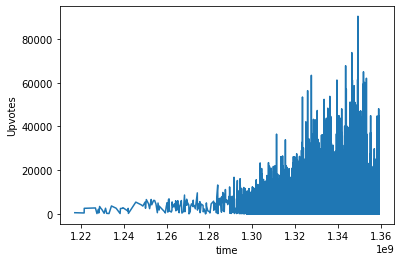

In [ ]:
from collections import defaultdict
import json
import numpy 
import matplotlib.pyplot as plt
import os
from math import log

data=load_data()
unixtime=[]
upvotes=[]
downvotes=[]
comments=[]
score=[]
features=[]
votes=[]
user=[]
image=[]
isfunny=[]
isgif=[]
localtime=[]
length=len(data)
title=[]
time1=[]
v1=[]
time10005=[]
v2=[]
time1001=[]
v3=[]
community=defaultdict(list)
index=0

for record in data:
	unixtime.append(float(record.get('unixtime')))
	upvotes.append(float(record.get('number_of_upvotes')))
	downvotes.append(float(record.get('number_of_downvotes')))
	comments.append(float(record.get('number_of_comments')))
	score.append(float(record.get('score')))
	votes.append(float(record.get('total_votes')))
	user.append(record.get('username'))
	image.append(record.get('image_id'))
	title.append(record.get('title'))

	community[record.get('subreddit')].append(index)

	if record.get('subreddit')=='funny':
		isfunny.append(1)
	else:
		isfunny.append(0)
	if record.get('subreddit')=='gif':
		isgif.append(1)
	else:
		isgif.append(0)
	t=record.get('rawtime')
	te=t.split('-')
	temp=[]
	temp.append(int(te[0]))
	temp.append(int(te[1]))
	day=te[2].split('T')

	localtime.append([int(te[0]),int(te[1]),int(day[0])])

year=2012

day=3 #5,6,13

test=[]
userdetect=[]
timedetect=[]
noone=[]
imagedetect=defaultdict(int)
length=len(data)
timedic=defaultdict(int)
yeartime1=defaultdict(int)
yeartime2=defaultdict(int)
yeartime3=defaultdict(int)

for i in range(length):
	test.append((upvotes[i],title[i],user[i],localtime[i],isfunny[i],isgif[i]))
	userdetect.append((upvotes[i],user[i]))
	if localtime[i][0]==2010:
		yeartime1[localtime[i][1]]+=upvotes[i]
	if localtime[i][0]==2011:
		yeartime2[localtime[i][1]]+=upvotes[i]
	if localtime[i][0]==2012:
		yeartime3[localtime[i][1]]+=upvotes[i]
	if user[i]=='':
		noone.append(upvotes[i])
	timedic[(localtime[i][0],localtime[i][1],localtime[i][2])]+=1
	imagedetect[image[i]]+=1
	timedetect.append((unixtime[i],upvotes[i]))
timedetect.sort()
x=[]
y=[]
for (ti,up) in timedetect:
	x.append(ti)
	y.append(up)

print(x)

plt.plot(x,y)
plt.xlabel("time")
plt.ylabel("Upvotes")

plt.show()
noone.sort()
noone.reverse()


In [ ]:

##plot for each weekday

from collections import defaultdict
import json
import numpy 
import matplotlib.pyplot as plt
import os
from math import log

data=load_data()
# unixtime=[]
year = ['2010','2011','2012']
for x in range(0,3):   
  rows = 7
  cols = 12
  
  m = [[0 for _ in range(cols)] for _ in range(rows)]
  for record in data:
    a = record.get('rawtime')
    if(a[0:4] == year[x]):
      i = int(a[5:7])-1
      if (record.get('subreddit')=='funny'):
        m[1][i] = m[1][i] + int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
      elif (record.get('subreddit')=='gif'):
        m[2][i] = m[2][i] + int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
      elif (record.get('subreddit')=='gaming'):
        m[3][i] = m[3][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
      elif (record.get('subreddit')=='atheism'):
        m[4][i] = m[4][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
      elif (record.get('subreddit')=='pics'):
        m[5][i] = m[5][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
      else:
        m[6][i] = m[6][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))

    
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8))

  br1 = np.arange(12)
  br2 = [x  for x in br1]
  br3 = [x  for x in br2]
  br4 = [x  for x in br3]
  br5 = [x  for x in br4]
  br6 = [x  for x in br5]
  
  # Make the plot
  plt.bar(br1, m[1], color ='g', width = barWidth, edgecolor ='grey', label ='Funny')
  plt.bar(br2, m[2], color ='y', width = barWidth, edgecolor ='yellow', label ='Gif')
  plt.bar(br3, m[3], color ='b', width = barWidth,edgecolor ='black', label ='gaming')
  plt.bar(br4, m[4], color ='r', width = barWidth, edgecolor ='red', label ='atheism')
  plt.bar(br5, m[5], color ='b', width = barWidth, edgecolor ='blue', label ='pics')
  plt.bar(br6, m[6], color ='cyan', width = barWidth, edgecolor ='cyan', label ='Others')
  
  # Adding Xticks
  plt.xlabel('Month', fontweight ='bold', fontsize = 15)
  plt.ylabel('Attention (Total votes +comments), '+ year[x], fontweight ='bold', fontsize = 15)
  plt.xticks([r for r in range(12)],["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov", "Dec"],fontsize = 15)
  
  plt.legend()
  print(year[x])
  if(year[x]=='2010'):
    plt.savefig('fig1.png')
  elif(year[x]=='2011'):
    plt.savefig('2011_1.png')
  else:
    plt.savefig('2012_1.png')
  plt.show()

In [ ]:
#plot for each hour of a day
rows = 7
cols = 24
l=[]
m = [[0 for _ in range(cols)] for _ in range(rows)]
for record in data:
  a = record.get('rawtime')
  i = int(a[11:13])-1
  if (record.get('subreddit')=='funny'):
    m[1][i] = m[1][i] + int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='gif'):
    m[2][i] = m[2][i] + int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='gaming'):
    m[3][i] = m[3][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='atheism'):
    m[4][i] = m[4][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='pics'):
    m[5][i] = m[5][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  else:
    l.append(record.get('subreddit'))
    m[6][i] = m[6][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))

barWidth = 0.25
fig = plt.subplots(figsize =(24, 8))

br1 = np.arange(24)
br2 = [x  for x in br1]
br3 = [x  for x in br2]
br4 = [x  for x in br3]
br5 = [x  for x in br4]
br6 = [x  for x in br5]
 
# Make the plot
plt.bar(br1, m[1], color ='g', width = barWidth, edgecolor ='grey', label ='Funny')
plt.bar(br2, m[2], color ='y', width = barWidth, edgecolor ='yellow', label ='Gif')
plt.bar(br3, m[3], color ='b', width = barWidth,edgecolor ='black', label ='gaming')
plt.bar(br4, m[4], color ='r', width = barWidth, edgecolor ='red', label ='atheism')
plt.bar(br5, m[5], color ='b', width = barWidth, edgecolor ='blue', label ='pics')
plt.bar(br6, m[6], color ='y', width = barWidth, edgecolor ='yellow', label ='Others')
 
# Adding Xticks
plt.xlabel('time (UTC)', fontweight ='bold', fontsize = 20)
plt.ylabel('Attention and engagament', fontweight ='bold', fontsize = 20)
plt.xticks([r for r in range(24)],["12 AM","1 AM","2 AM","3 AM","4 AM","5 AM","6 AM","7 AM","8 AM","9 AM","10 AM","11 AM","12 PM","1 PM","2 PM","3 PM","4 PM","5 PM","6 PM","7 PM","8 PM","9 PM","10 PM","11 PM"], fontsize = 15)
plt.title("Average success over time")
plt.legend()
plt.show()

In [ ]:
#plotting for day of a week
rows = 7
cols = 7
def convertNumToDay(num):
 weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
 return weekdays[num-1]
m = [[0 for _ in range(cols)] for _ in range(rows)]
for record in data:
  a = record.get('rawtime')
  today = datetime.datetime(int(a[:4]), int(a[5:7]), int(a[8:10]),int(a[11:13]),int(a[14:16]),int(a[17:19]))
  i = (today.weekday())
  if (record.get('subreddit')=='funny'):
    m[1][i] = m[1][i] + int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='gif'):
    m[2][i] = m[2][i] + int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='gaming'):
    m[3][i] = m[3][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='atheism'):
    m[4][i] = m[4][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  elif (record.get('subreddit')=='pics'):
    m[5][i] = m[5][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))
  else:
    m[6][i] = m[6][i] +  int(record.get('number_of_comments'))+ int(record.get('number_of_upvotes'))

barWidth = 0.25
fig = plt.subplots(figsize =(7, 8))

br1 = np.arange(7)
br2 = [x  for x in br1]
br3 = [x  for x in br2]
br4 = [x  for x in br3]
br5 = [x  for x in br4]
br6 = [x  for x in br5]
 
# Make the plot
plt.bar(br1, m[1], color ='g', width = barWidth, edgecolor ='grey', label ='Funny')
plt.bar(br2, m[2], color ='b', width = barWidth, edgecolor ='blue', label ='Gif')
plt.bar(br3, m[3], color ='b', width = barWidth,edgecolor ='black', label ='gaming')
plt.bar(br4, m[4], color ='r', width = barWidth, edgecolor ='red', label ='atheism')
plt.bar(br5, m[5], color ='b', width = barWidth, edgecolor ='blue', label ='pics')
plt.bar(br6, m[6], color ='y', width = barWidth, edgecolor ='yellow', label ='Others')
 
# Adding Xticks
plt.xlabel('time (UTC)', fontweight ='bold', fontsize = 15)
plt.ylabel('Attention and engagament', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(7)],['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat'],fontsize = 20)
plt.title("Average success over time")
plt.legend()
plt.show()